In [1]:
from keras.models import load_model
model = load_model('vgg16.h5')

from keras import backend as K
K.set_image_dim_ordering('th')

Using TensorFlow backend.


In [24]:
import tensorflow as tf
from keras.models import Model
from keras.layers.convolutional import UpSampling2D, ZeroPadding2D, Conv2D
from keras.layers.local import LocallyConnected1D
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation, Input, Lambda, Flatten, Dense, Reshape
#from keras.layers.activation import softmax
from keras.optimizers import SGD
import keras.activations
import numpy as np

# https://github.com/jocicmarko/ultrasound-nerve-segmentation/blob/master/train.py#L19
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def addConv(x, n, filters, activation='relu'):
    for _ in range(n):
        x = ZeroPadding2D(1)(x)
        x = Conv2D(filters, 3)(x)
        x = BatchNormalization()(x)
        x = Activation(activation) (x)
    return x


inp = Input(shape=(1,224,224))
x = Lambda(lambda y:tf.tile(y,[1,3,1,1])) (inp)

m = Model(inputs = model.inputs, outputs = model.layers[15].output)
m.trainable = False
x = m(x)

x = UpSampling2D(2)(x)
x = addConv(x, 2, 128)
'''
x = UpSampling2D(2)(x)
x = addConv(x, 2, 64)

x = UpSampling2D(2)(x)
x = addConv(x, 2, 64)
'''
x = UpSampling2D(2)(x)
x = addConv(x, 2, 32)
x = addConv(x, 1, 2,'softmax')

m2 = Model(inputs = inp, outputs = x)
sgd = SGD(lr=1e1)
#m2.summary()
#m2.compile(loss=dice_coef_loss, optimizer='adadelta',metrics=[dice_coef,'accuracy'])
m2.compile(loss='binary_crossentropy', optimizer='adadelta',metrics=['binary_crossentropy'])

In [21]:
m2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 1, 224, 224)       0         
_________________________________________________________________
lambda_6 (Lambda)            (None, 3, 224, 224)       0         
_________________________________________________________________
model_11 (Model)             (None, 256, 56, 56)       1735488   
_________________________________________________________________
up_sampling2d_11 (UpSampling (None, 256, 112, 112)     0         
_________________________________________________________________
zero_padding2d_22 (ZeroPaddi (None, 256, 114, 114)     0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 128, 112, 112)     295040    
_________________________________________________________________
batch_normalization_22 (Batc (None, 128, 112, 112)     448       
__________

In [9]:
np.concatenate((train_y,train_y),axis=1).shape

NameError: name 'train_y' is not defined

In [7]:
from scipy.misc import imresize
def preprocess_labels(labels):
    pos = np.where(labels==1)
    new_labels = np.concatenate((labels,labels),axis=1)
    new_labels.fill(0)
    new_labels[:,0]= 1
    new_labels[pos[0], 0, pos[2],pos[3]] = 0
    new_labels[pos[0], 1, pos[2],pos[3]] = 1
    #new_labels = new_labels.transpose((2,0,1))
    return new_labels

def preprocess(mri_slice):
    img0 = imresize(mri_slice, (224,224))
    img0.resize((img0.shape[0],img0.shape[1],1))
    img0 = img0.transpose((2,0,1))
    return np.expand_dims(img0, axis=0)

In [66]:
#f = h5py.File('dataset_1_equal.h5', 'r')
#train_y = f['train_y'][:end]
#f.close()
#pre = train_y.reshape(train_y.shape[0],train_y.shape[2],train_y.shape[3])
np.where(pre==None)
#np.where(train_y==None)
#pre = preprocess_labels1(train_y)
#img = pre[18]
#pos = np.where(np.argmax(img, axis=0)>0)
#img1 = np.zeros((img.shape[1],img.shape[2]))
#img1[pos[0],pos[1]] = 1
#print(img1.shape)
#plt.imshow(img1)
#m2.reset_states()

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:5: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


(array([], dtype=int64),)

1/1 [==============================] - 0s
[6.3183422088623047, 6.3183426856994629]
Epoch 1/5
100/100 [==============================] - 17s - loss: 2.7175 - binary_crossentropy: 2.7175     

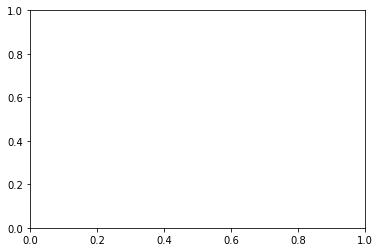

In [25]:
import h5py
cont = 0
initial_epoch = 0
epochs = 5
fig, ax = plt.subplots(1,1)
for i in range(0,100,100):
    start = cont+i
    end = start+100
    with h5py.File('dataset_1_patches_only.h5', 'r') as f:
        train_x = f['train_x'][start:end]
        train_y = preprocess_labels(f['train_y'][start:end])
        #train_y = f['train_y'][start:end]
        #train_y = train_y.reshape(train_y.shape[0],train_y.shape[2],train_y.shape[3])
        print(m2.evaluate(train_x[0:1],train_y[0:1],batch_size=5))
        m2.fit(train_x,train_y,epochs=initial_epoch+epochs,batch_size=5,initial_epoch=initial_epoch,shuffle="batch")
        #draw_fig(fig,ax)
    initial_epoch+=epochs

In [15]:
def draw_fig(fig,ax):
    fig.clear()
    img= m2.predict(preprocess(mri_data[predict_slide])).squeeze()
    ax.imshow(imresize(mri_data[predict_slide], (224,224)),cmap=plt.cm.gray)
    ax.imshow(np.ma.masked_where(img1<.5, img1),alpha=.7,cmap=plt.cm.autumn, interpolation='none')
    print (img.sum())

In [58]:
img.max()

0.9999994

In [5]:
# Get image data w/ nibabel
import nibabel as nib
def get_data(filename):
    img = nib.load(filename)
    return img.get_data()
def scale(array):
    return (array-np.min(array))/(np.max(array) - np.min(array))    
mri_data = scale(get_data('../data/case_001_2.nii.gz')).transpose((2,0,1))
labelled_data = get_data('../data/case_001_labels.nii.gz').transpose((2,0,1))

19049

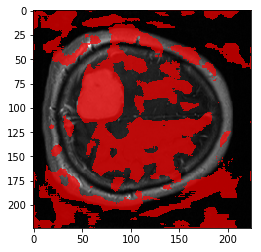

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt

predict_slide = 25
img= m2.predict(preprocess(mri_data[predict_slide])).squeeze()
#img= pre[1]
img1 = np.argmax(img, axis=0)
#img1/=img1.max()
#pos = np.where(np.argmax(img, axis=0)>0)
#img1 = np.zeros((img.shape[1],img.shape[2]))
#img1[pos[0],pos[1]] = 1
fig, ax = plt.subplots(1,1)

ax.imshow(imresize(mri_data[predict_slide], (224,224)),cmap=plt.cm.gray)
ax.imshow(np.ma.masked_where(img1<.5, img1),alpha=.7,cmap=plt.cm.autumn, interpolation='none')
img1.sum()

In [163]:
np.argmax(img, axis=0).shape

(224, 224)